In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd 
from src.vae import CrossSpeciesVAE
# from src.backup import CrossSpeciesVAE
from src.data import CrossSpeciesDataModule
import pickle
from sklearn.metrics import adjusted_mutual_info_score
import scanpy as sc
import matplotlib.pyplot as plt
import umap

fn1 = '../samap/example_data/planarian.h5ad'
fn2 = '../samap/example_data/schistosome.h5ad'
fn3 = '../samap/example_data/hydra.h5ad'

eggnogs = '../samap/example_data/eggnog/*'

adata1 = anndata.read_h5ad(fn1)
adata2 = anndata.read_h5ad(fn2)
adata3 = anndata.read_h5ad(fn3)
adata3.var_names = pd.Index([i.split('_')[-1] for i in adata3.var_names])

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# gene_embeddings, gene_ids = pickle.load(open('species_tsvd_gene_embeddings.pkl','rb'))
# gene_embeddings={k: torch.tensor(v) for k,v in gene_embeddings.items()}
homology_edges, homology_scores = pickle.load(open('species_homology_info.pkl','rb'))

batch_size = 256
species_data = {
    "planarian": adata1,
    "schisto": adata2,
    "hydra": adata3,
}

data_module = CrossSpeciesDataModule(
    species_data = species_data,
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    seed=0
)
data_module.setup()

species_vocab_sizes = data_module.species_vocab_sizes

# Initialize the model using data module properties
model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    homology_edges=homology_edges,
    homology_scores=homology_scores,
    n_latent=128,
    hidden_dims=[128],
    dropout_rate=0.2,
    base_learning_rate=1e-3,
    batch_size=batch_size,
    base_batch_size=32,
    min_learning_rate=1e-5,
    warmup_epochs=1.0,
    init_beta=1e-3,
    final_beta=1,
    gradient_clip_val=1.0,
    gradient_clip_algorithm="norm",
    # loss weights
    recon_weight=1.0,
    homology_weight=1.0,
)

early_stopping = EarlyStopping(
    monitor='val_homology',
    min_delta=0.0,
    patience=10,
    verbose=True,
    mode='min'
)

# Initialize the trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=300,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=10,
    deterministic=True,
    callbacks=[ModelCheckpoint(
        dirpath="checkpoints",
        filename="crossspecies_vae-{epoch:02d}",
        every_n_epochs=5,
        save_top_k=1,
        monitor="val_recon",
        mode="min"
    ), early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=False,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /opt/jupyter-envs/generate-cross-species/atar-vscode/work/cross-species-vae/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | mu_layer        | Linear        | 16.5 K | train
1 | logvar_layer    | Linear        | 16.5 K | train
2 | encoders        | ModuleDict    | 27.0 M | train
3 | decoders        | ModuleDict    | 18.0 M | tr

Current epoch: 0 Current stage:  transform_recon


Metric val_homology improved. New best score: 0.000


Current epoch: 1 Current stage:  homology_loss


Metric val_homology improved by 0.406 >= min_delta = 0.0. New best score: -0.406


Current epoch: 2 Current stage:  transform_recon
Current epoch: 3 Current stage:  homology_loss


Metric val_homology improved by 0.419 >= min_delta = 0.0. New best score: -0.825


Current epoch: 4 Current stage:  transform_recon
Current epoch: 5 Current stage:  homology_loss


Metric val_homology improved by 0.082 >= min_delta = 0.0. New best score: -0.907


Current epoch: 6 Current stage:  transform_recon
Current epoch: 7 Current stage:  homology_loss


Metric val_homology improved by 0.087 >= min_delta = 0.0. New best score: -0.994


Current epoch: 8 Current stage:  transform_recon
Current epoch: 9 Current stage:  homology_loss


Metric val_homology improved by 0.069 >= min_delta = 0.0. New best score: -1.063


Current epoch: 10 Current stage:  transform_recon


Best model path: /opt/jupyter-envs/generate-cross-species/atar-vscode/work/cross-species-vae/checkpoints/crossspecies_vae-epoch=104.ckpt


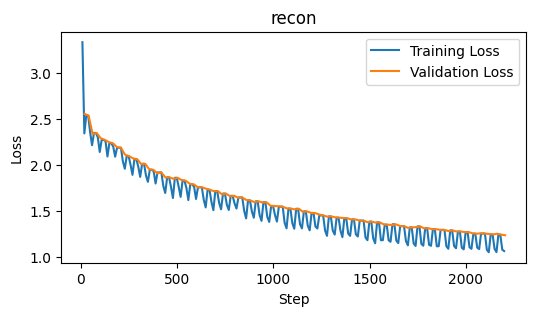

In [12]:
# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["recon"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}'][df[f'val_{loss_type}'] != 0.0]
    val_step = df['step'][df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

    
best_model_path = trainer.callbacks[-1].best_model_path
print("Best model path:", best_model_path)
# # Load the checkpoint
# checkpoint = torch.load(best_model_path)

# # Create a new model with the same hyperparameters and homology information
# model = CrossSpeciesVAE(
#     homology_edges=homology_edges,  # Need to pass these again
#     **checkpoint['hyper_parameters']  # This loads all other hyperparameters
# )

# # Load the state dict
# model.load_state_dict(checkpoint['state_dict'])

In [13]:
df

,epoch,step,train_homology,train_kl,train_loss,train_recon,val_homology,val_kl,val_loss,val_recon
0,0,9,0.000000,1.514727,3.340598,3.339083,NaN,NaN,NaN,NaN
1,0,19,0.000000,6.498038,2.350389,2.343891,NaN,NaN,NaN,NaN
2,0,20,NaN,NaN,NaN,NaN,0.000000,6.670932,2.564245,2.557574
3,1,29,-0.049676,6.670467,-0.049676,2.539042,NaN,NaN,NaN,NaN
4,1,39,-0.120849,6.670467,-0.120849,2.539042,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
320,103,2179,-0.536106,0.152001,-0.536106,1.240133,NaN,NaN,NaN,NaN
321,103,2183,NaN,NaN,NaN,NaN,-0.541852,0.152001,-0.541852,1.240133
322,104,2189,-0.542264,0.227461,1.155215,1.076213,NaN,NaN,NaN,NaN
323,104,2199,-0.542264,0.188480,1.126229,1.060766,NaN,NaN,NaN,NaN


0.5795067485213568
0.4582393337442674
0.6330487385738699


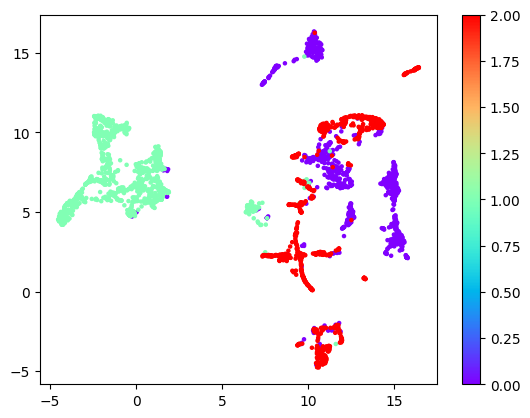

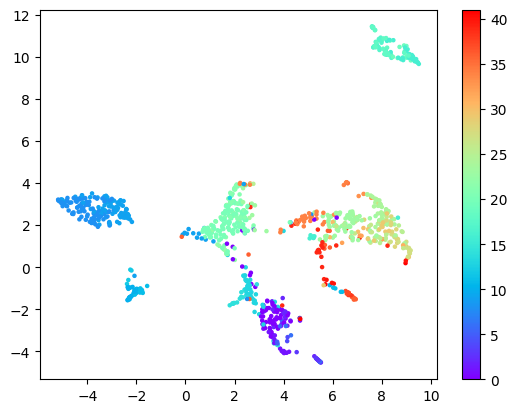

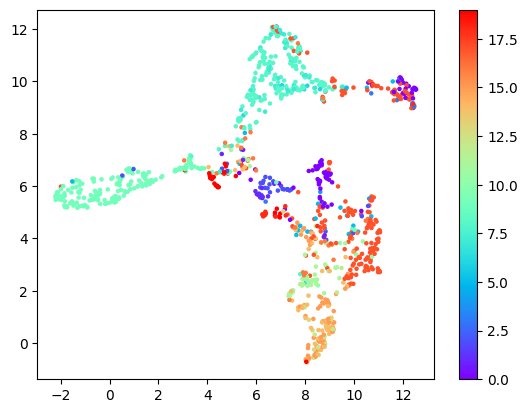

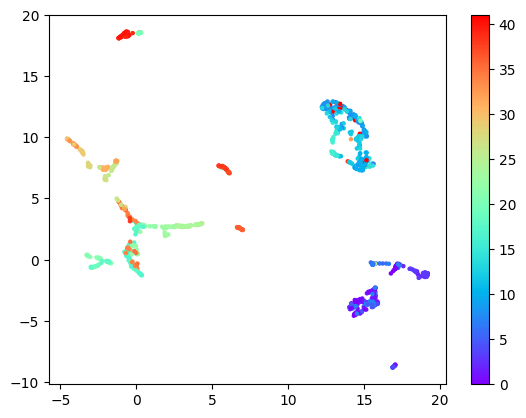

In [5]:

output, s = model.get_latent_embeddings(species_data)
s=s.cpu().numpy()

plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1, 2], [adata1, adata2, adata3], ['cluster', 'cluster_t', 'Cluster']):
    dt = umap.UMAP(n_components=2).fit_transform(output[s==i])

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

In [6]:
from scipy.stats import spearmanr

for i, adata in enumerate([adata1, adata2, adata3]):
    x = model.encoders[str(i)].gene_importance(torch.tensor(adata.X.toarray()).to('cuda')).detach().cpu().numpy()
    mu = x.mean(0)
    mu[mu==0]=1
    a = x.var(0)/mu
    b = adata.var['weights'].values

    # plt.figure(); plt.scatter(a,b,s=1);
    # plt.figure(); plt.scatter(x.var(0),adata.X.toarray().var(0),s=1);    
    print(i)
    print('pearson',np.corrcoef(a,b)[0,1])
    print('spearman',spearmanr(a,b).statistic)


0
pearson 0.24598314708705576
spearman 0.28940616952097026
1
pearson 0.2054413664406546
spearman 0.13445574667091645
2
pearson 0.4991611013718559
spearman 0.8276285982395746


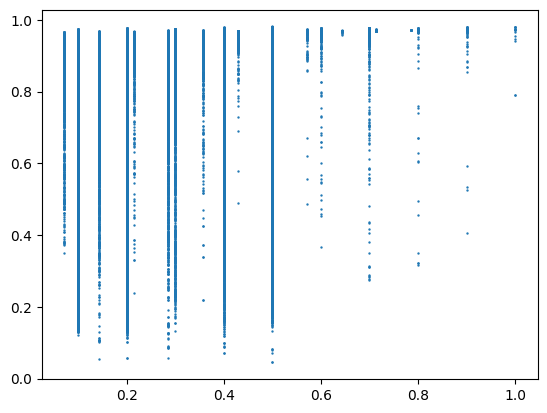

In [6]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

x=[]
y=[]
for i in range(len(set(s))):
    for j in range(i+1,len(set(s))):
        x.extend(homology_scores[i][j]/homology_scores[i][j].max())
        x.extend(homology_scores[j][i]/homology_scores[j][i].max())        
        y.extend(list(sigmoid(model.homology_scores[str(i)][str(j)].detach().cpu().numpy())))
        y.extend(list(sigmoid(model.homology_scores[str(j)][str(i)].detach().cpu().numpy())))
x=np.array(x)
y=np.array(y)
plt.figure(); plt.scatter(x,y,s=0.5);

In [7]:
latent = output.cpu().numpy()
adatas = []
for i, k in enumerate(species_data):
    adata = species_data[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')
adata.obsm['X_umap'] = dt_full

# adata.write_h5ad('test.h5ad')

In [8]:
import scanpy as sc

sc.external.pp.harmony_integrate(adata, "species", basis='emb', adjusted_basis='X_pca_harmony')

2024-12-02 06:30:20,790 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-02 06:30:21,059 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-02 06:30:21,070 - harmonypy - INFO - Iteration 1 of 10
2024-12-02 06:30:21,381 - harmonypy - INFO - Iteration 2 of 10
2024-12-02 06:30:21,695 - harmonypy - INFO - Iteration 3 of 10
2024-12-02 06:30:22,001 - harmonypy - INFO - Iteration 4 of 10
2024-12-02 06:30:22,292 - harmonypy - INFO - Iteration 5 of 10
2024-12-02 06:30:22,585 - harmonypy - INFO - Iteration 6 of 10
2024-12-02 06:30:22,787 - harmonypy - INFO - Iteration 7 of 10
2024-12-02 06:30:22,989 - harmonypy - INFO - Iteration 8 of 10
2024-12-02 06:30:23,188 - harmonypy - INFO - Iteration 9 of 10
2024-12-02 06:30:23,480 - harmonypy - INFO - Iteration 10 of 10
2024-12-02 06:30:23,682 - harmonypy - INFO - Stopped before convergence


In [9]:
adata.obsm['X_umap'] = umap.UMAP().fit_transform(adata.obsm['X_pca_harmony'])

In [10]:
adata.write_h5ad('test.h5ad')

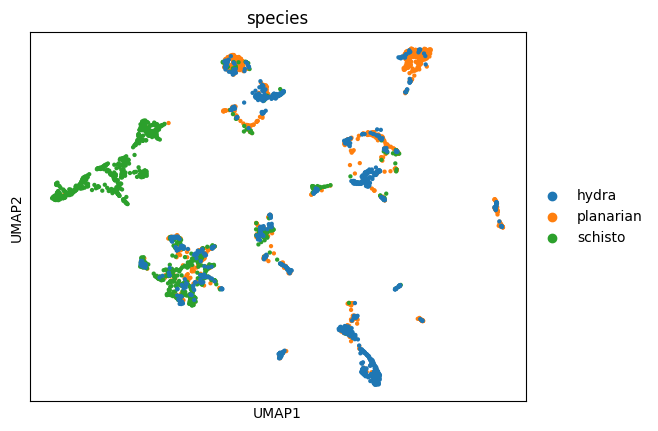

In [11]:
sc.pl.umap(adata, color ='species')

In [10]:
import numpy as np
from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=5, metric='euclidean'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

latent = output.cpu().numpy()

In [11]:
indices,distances = find_nearest_neighbors(latent[s==0],latent[s==1])

In [19]:
c1 = np.array(list(adata1.obs['tissue']))
c2 = np.array(list(adata2.obs['tissue']))

A = c1[np.tile(np.arange(c1.size)[:,None],(1,5))]
B = c2[indices]

In [26]:
a,c = np.unique(A + '--' + B,return_counts=True)
a[np.argsort(-c)]

array(['Neural--Neural', 'Neoblast--Cathepsin',
       'Epidermal--Tegument_prog', 'Epidermal--Cathepsin',
       'Epidermal--Neoblast', 'Cathepsin+ cells--Cathepsin',
       'Neoblast--Intestine', 'Neural--Parenchymal',
       'Cathepsin+ cells--Neural_KK7', 'Cathepsin+ cells--Neural',
       'Intestine--Cathepsin', 'Muscle--Parenchymal', 'Neural--Neoblast',
       'Muscle--Neural_KK7', 'Cathepsin+ cells--Parenchymal',
       'Neoblast--Muscle', 'Muscle--Neoblast', 'Neural--Muscle',
       'Pharynx--Neural', 'Muscle--Intestine', 'Neural--Flame cells',
       'Cathepsin+ cells--Intestine', 'Parapharyngeal--Muscle',
       'Intestine--Intestine', 'Neoblast--Neoblast', 'Neural--Cathepsin',
       'Protonephridia--Neural', 'Parapharyngeal--Neoblast',
       'Epidermal--Tegument', 'Muscle--Neural', 'Epidermal--Muscle',
       'Epidermal--Neural', 'Protonephridia--Cathepsin', 'Muscle--Gland',
       'Epidermal--Intestine', 'Intestine--Muscle',
       'Intestine--Tegument_prog', 'Neural--Int

In [23]:
pd.DataFrame(B[:20])

,0,1,2,3,4
0,Intestine,Cathepsin,Cathepsin,Neural_KK7,Cathepsin
1,Intestine,Cathepsin,Cathepsin,Neural_KK7,Cathepsin
2,Muscle,Intestine,Cathepsin,Cathepsin,Cathepsin
3,Cathepsin,Neoblast,Tegument_prog,Neoblast,Tegument_prog
4,Muscle,Cathepsin,Intestine,Cathepsin,Intestine
5,Muscle,Intestine,Muscle,Neural,Cathepsin
6,Cathepsin,Intestine,Cathepsin,Cathepsin,Parenchymal
7,Muscle,Neoblast,Parenchymal,Cathepsin,Neural
8,Cathepsin,Cathepsin,Intestine,Cathepsin,Cathepsin
9,Neural_KK7,Cathepsin,Gland,Neural_KK7,Parenchymal


In [15]:
B.shape

(1049, 5)

In [41]:
A1 = A[:1049].copy()
A1[i1 < 1049] = "nan"

B1 = B[:1049].copy()
B1[i1 < 1049] = "nan"

B1[:,0] = B[:1049,0]

In [46]:
i1

array([[   0,  293,  544,  531,  306],
       [   1,  449,  760,  329,  104],
       [   2,    5,  678,  840,  669],
       ...,
       [1046, 1509, 1841, 1347, 1924],
       [1047,  234,  412,  984,  479],
       [1048, 1001,  286,  966,  806]], dtype=int32)

In [43]:
pd.DataFrame(B1[(B1[:,1:]=='nan').sum(1) < 4])

,0,1,2,3,4
0,Neural: 1,nan,nan,nan,Neural: 23
1,Pharynx: 25,nan,nan,nan,Parapharyngeal: 12
2,Parapharyngeal: 12,nan,Parapharyngeal: 12,Parapharyngeal: 12,Neoblast: 0
3,Neural: 1,nan,Parapharyngeal: 12,i_smgc1,nan
4,Protonephridia: 26,Neoblast: 0,Neoblast: 0,Neoblast: 0,nan
5,Neural: 9,nan,nan,nan,Neural: 20
6,Neural: 9,nan,nan,nan,Neural: 23
7,Neoblast: 5,Muscle: 14,Muscle: 14,Muscle: 14,Muscle: 14
8,Parapharyngeal: 12,nan,nan,Parapharyngeal: 12,Muscle: 14
9,Neural: 36,nan,nan,enEp_head,nan


In [ ]:
A1

In [34]:
B1

array([['Intestine', 'nan', 'nan', 'nan', 'nan'],
       ['Intestine', 'nan', 'nan', 'nan', 'nan'],
       ['Neoblast', 'nan', 'nan', 'nan', 'nan'],
       ...,
       ['Epidermal', 'Neural', 'Neural', 'Parenchymal', 'Neural'],
       ['Neural', 'nan', 'nan', 'nan', 'nan'],
       ['Neural', 'nan', 'nan', 'nan', 'nan']], dtype='<U16')

In [28]:
i1

array([[   0,  293,  544,  531,  306],
       [   1,  449,  760,  329,  104],
       [   2,    5,  678,  840,  669],
       ...,
       [1046, 1509, 1841, 1347, 1924],
       [1047,  234,  412,  984,  479],
       [1048, 1001,  286,  966,  806]], dtype=int32)

In [27]:
A1

array([['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ...,
       ['nan', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['nan', 'nan', 'nan', 'nan', 'nan'],
       ['nan', 'nan', 'nan', 'nan', 'nan']], dtype='<U16')

In [37]:
c1[:20]

array([['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Intestine', 'Intestine', 'Intestine', 'Intestine', 'Intestine'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Neural', 'Neural', 'Neural', 'Neural', 'Neural'],
       ['Cathepsin+ cells', 'Cathepsin+ cells', 'Cathepsin+ cells',
        'Cathepsin+ cells', 'Cathepsin+ cells'],
       ['Muscle', 'Muscle', 'Muscle', 'Muscle', 'Muscle'],
       ['Epidermal', 'Epidermal', 'Epidermal', 'Epidermal', 'Epidermal'],
       ['Neoblast', 'Neoblast', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Epi

In [38]:
c2[:20]

array([['Parenchymal', 'Neoblast', 'Neoblast', 'Neural', 'Intestine'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Parenchymal', 'Neoblast', 'Neoblast', 'Neural', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neural'],
       ['Neural', 'Muscle', 'Parenchymal', 'Neoblast', 'Neural'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neural', 'Neoblast'],
       ['Parenchymal', 'Neoblast', 'Tegument_prog', 'Neural', 'Neoblast'],
       ['Parenchymal', 'Neoblast', 'Neural', 'Neoblast', 'Intestine'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neural', 'Neoblast'],
       ['Neoblast', 'Parenchymal', 'Neoblast', 'Neoblast', 'Neoblast'],
       ['Parenchymal', 'Neural', 'Neoblast', 'Neoblast', 'Intestine'],
       ['Ne